# CLV 6-MONTH TARGET CONSTRUCTION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 100)

## Step 1: Load Cleaned Data

In [7]:
df = pd.read_csv("../data/processed/online_retail_II_clean.csv")

In [8]:
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country,is_cancelled,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397885 entries, 0 to 397884
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice       397885 non-null  int64  
 1   stock_code    397885 non-null  object 
 2   description   397885 non-null  object 
 3   quantity      397885 non-null  int64  
 4   invoice_date  397885 non-null  object 
 5   price         397885 non-null  float64
 6   customer_id   397885 non-null  float64
 7   country       397885 non-null  object 
 8   is_cancelled  397885 non-null  bool   
 9   revenue       397885 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 27.7+ MB


In [16]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"])

## Step 2: Define Cutoff Date

In [18]:
df["invoice_date"].max()

Timestamp('2011-12-09 12:50:00')

In [19]:
cutoff_date = pd.Timestamp("2011-06-01")
prediction_end_date = cutoff_date + pd.DateOffset(months=6)

cutoff_date, prediction_end_date

(Timestamp('2011-06-01 00:00:00'), Timestamp('2011-12-01 00:00:00'))

**Interpretation**:
- Features use data **before 2011-06-01**
- Target uses data **2011-06-01 until 2011-12-01**

## Step 3: Split Observation vs Prediction Windows

In [20]:
obs_df = df.loc[df["invoice_date"] < cutoff_date].copy()
pred_df = df.loc[
    (df["invoice_date"] >= cutoff_date) & (df["invoice_date"] < prediction_end_date)
].copy()

In [21]:
obs_df["invoice_date"].max(), pred_df["invoice_date"].min()

(Timestamp('2011-05-31 15:41:00'), Timestamp('2011-06-01 07:37:00'))

## Step 4: Compute CLV_6M (Target)

In [23]:
clv_6m = pred_df.groupby("customer_id", as_index=False).agg(clv_6m=("revenue", "sum"))

In [26]:
# customers present before cutoff gets target
customers_obs = obs_df["customer_id"].unique()

clv_6m = clv_6m.loc[clv_6m["customer_id"].isin(customers_obs)].copy()

In [27]:
# customers with zero future purchases should have CLV = 0
customer_df = pd.DataFrame({"customer_id": customers_obs})

customer_df = customer_df.merge(clv_6m, on="customer_id", how="left")

customer_df["clv_6m"] = customer_df["clv_6m"].fillna(0.0)

## Step 5: Target Variable EDA

**Distribution**

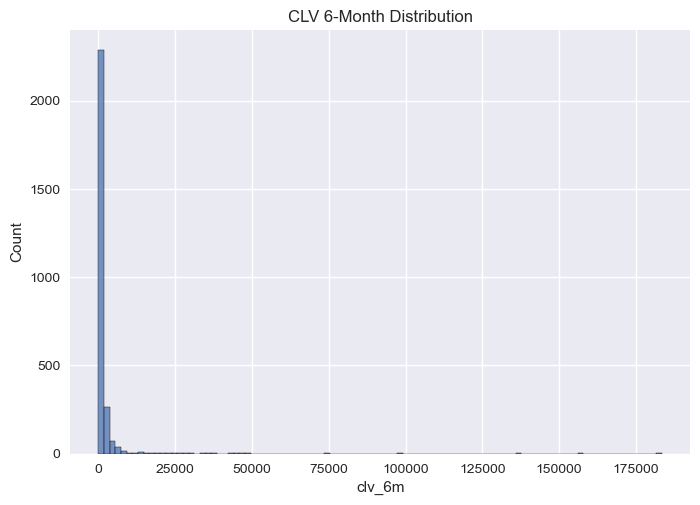

In [30]:
sns.histplot(customer_df["clv_6m"], bins=100)
plt.title("CLV 6-Month Distribution")
plt.show()

**Log Scale**

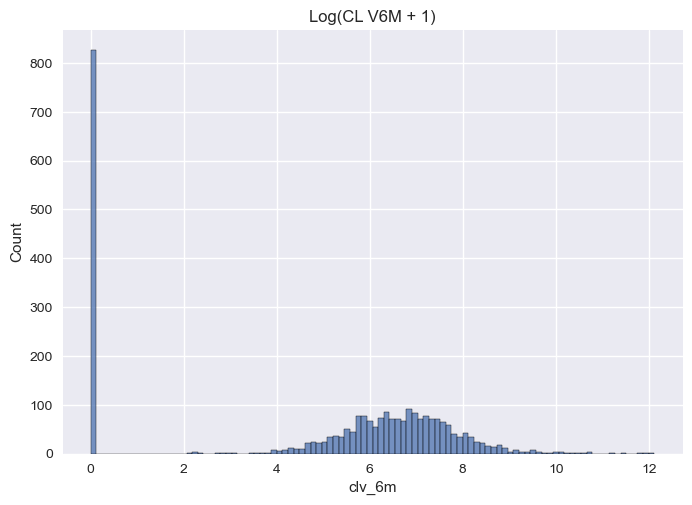

In [31]:
sns.histplot(np.log1p(customer_df["clv_6m"]), bins=100)
plt.title("Log(CL V6M + 1)")
plt.show()

**Key Target Statistics**

In [32]:
customer_df["clv_6m"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count      2718.000000
mean       1436.314552
std        6688.806620
min           0.000000
50%         397.880000
75%        1220.677500
90%        2623.281000
95%        4243.499000
99%       15518.739300
max      183529.650000
Name: clv_6m, dtype: float64

In [33]:
# check sparsity
(customer_df["clv_6m"] == 0).mean()

0.3038999264164827

In [34]:
# save to parquet
customer_df.to_parquet("../data/processed/customer_clv_6m.parquet", index=False)